# Image Super Resolution + Denoising

The main goal of this project is to tackle a problem of jointly denoising (only Gaussian noise is considered) and upsampling an image (super resolution).

Some code is already provided. You can modify most of the code unless specifically stated that some section should not be changed.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import shutil
from tqdm import tqdm
import random
random.seed(42) # DO NOT CHANGE THIS

# add more imports here
from torch.optim import Adam
from skimage.metrics import peak_signal_noise_ratio



## Loading the data

Let's start by loading the data. You can find the dataset [here](https://drive.google.com/file/d/1IQ-lQc14q3ROaaTJCMKIIH8dhaSM1B6a/view?usp=share_link).

Download the zip file and upload it to your google drive.

Let's now mount the drive and access the folder where you saved the dataset.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# access the data
#datadir = '/content/drive/MyDrive/dataset.zip' # change this path to where you stored the dataset
datadir = '/content/drive/MyDrive/PAIA/6_dataset_proj6.zip'


# unzip images
shutil.unpack_archive(datadir)

In [32]:
# DO NOT CHANGE THIS CELL
images_list = os.listdir('dataset/ground_truth')
random.shuffle(images_list)

train_list = images_list[:800]
val_list = images_list[800:900]
test_list = images_list[900:]
print(len(train_list), len(val_list), len(test_list))

800 100 100


## Visualizing the data

In the following section, you can use the function ``` display_image_grid ``` to visualize the data.

In [31]:
# note that you can use this function to visualize your model's predictions
def display_image_grid(images_filenames, images_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10,24))
    for i, image_filename in enumerate(images_filenames):
        gt = cv2.imread(os.path.join(images_directory, 'ground_truth', image_filename))

        input = np.load(os.path.join(images_directory, 'low_res_noisy_images', image_filename.replace('.jpg', '.npy')))
        print(input.shape, gt.shape)

        # plot
        ax[i, 0].imshow(input)
        ax[i, 1].imshow(gt)

        ax[i, 0].set_title("Input")
        ax[i, 1].set_title("Ground-truth")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            #predicted_mask = cv2.cvtColor(predicted_mask[i], cv2.COLOR_YCrCb2RGB)

            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)


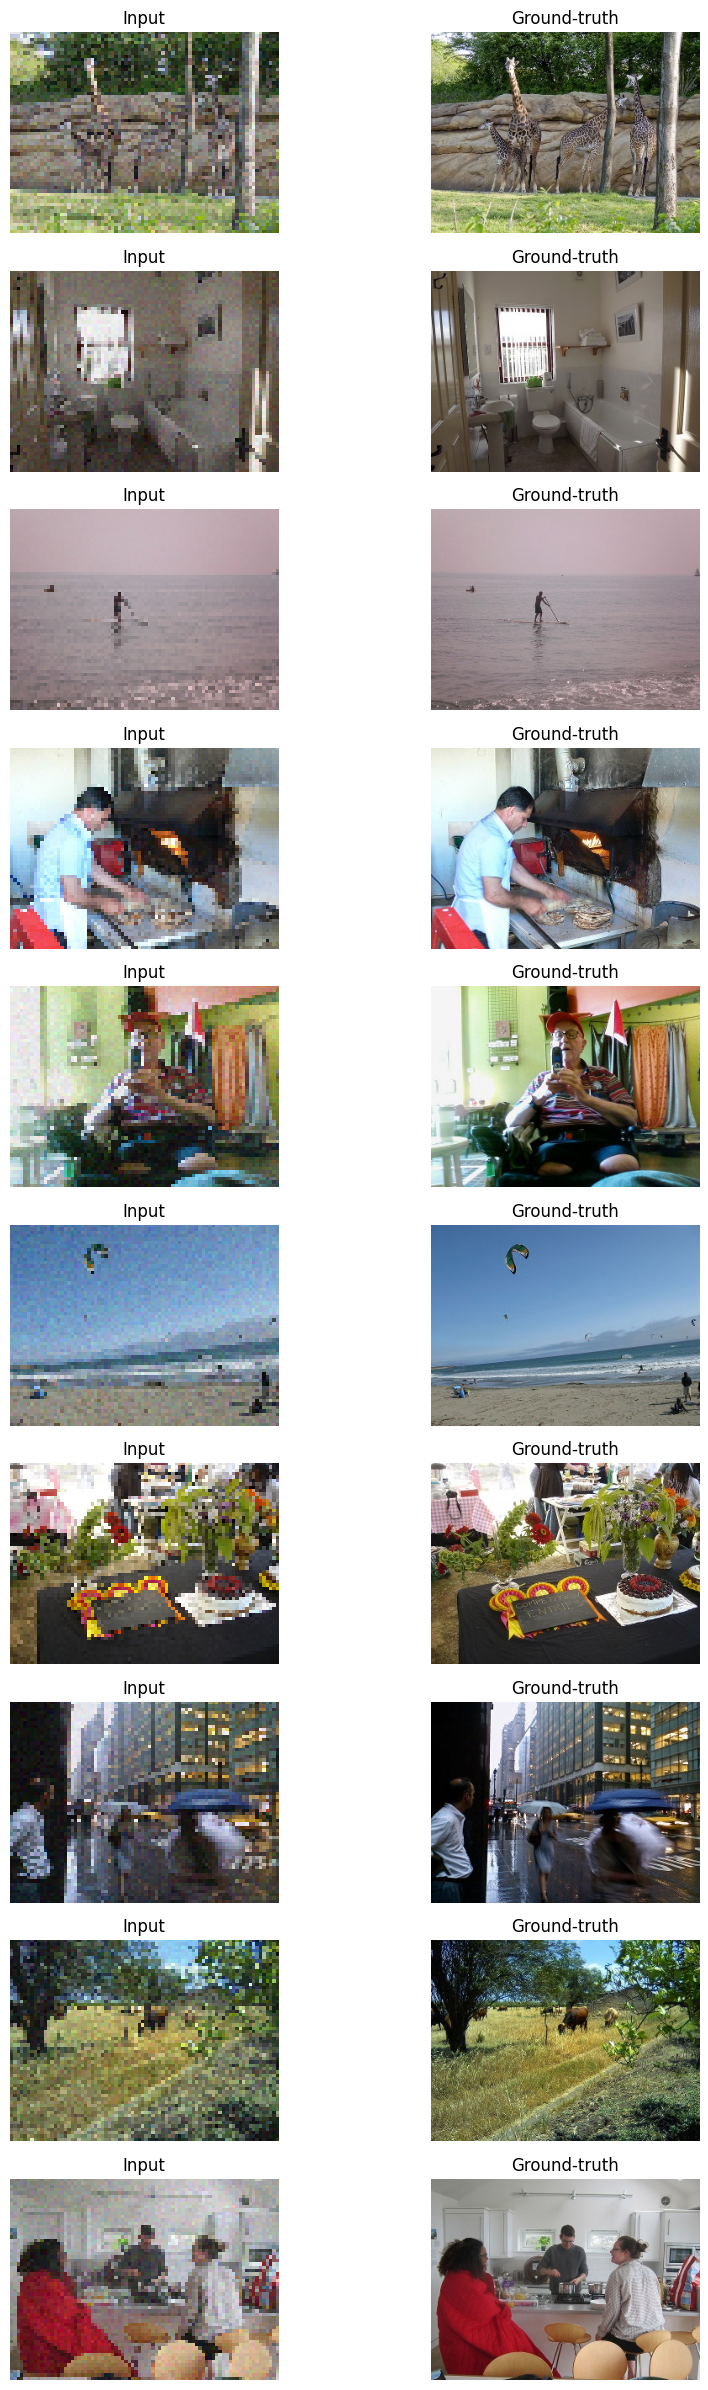

In [ ]:
display_image_grid(train_list[:10], 'dataset')

## Building the Dataset

In [30]:
class CustomDataset(Dataset):
    def __init__(self, images_list, images_directory='dataset', transform=transforms.ToTensor()): # add other params as needed
        self.images_list = images_list
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_list)
        # return the number of images in the dataset

    def __getitem__(self, idx):
        image_filename = self.images_list[idx]
        image = np.load(os.path.join(self.images_directory, 'low_res_noisy_images', image_filename.replace('.jpg', '.npy')))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ground_truth = cv2.imread(os.path.join('dataset', 'ground_truth', image_filename))
        ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

        #bicubic interpolation
        image_upscaled = cv2.resize(image, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)

        #convert to YCrCb color space and extract luminance channel (Y) and convert to float and normalize to range [0, 1]
        image_bicubic_ycc = cv2.cvtColor(image_upscaled, cv2.COLOR_RGB2YCrCb)
        image_bicubic_y = image_bicubic_ycc[:,:,0]
        image_bicubic_y = image_bicubic_y.astype(np.float32)

        ground_truth_ycc = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2YCrCb)
        ground_truth_y = ground_truth_ycc[:,:,0]
        ground_truth_y = ground_truth_y.astype(np.float32)


        if self.transform:
            image_bicubic_y = self.transform(image_bicubic_y)
            image_bicubic_ycc = self.transform(image_bicubic_ycc)
            ground_truth = self.transform(ground_truth)
            ground_truth_y = self.transform(ground_truth_y)

        return image_bicubic_y,image_bicubic_ycc, ground_truth, ground_truth_y

        # VDSR takes as input an upscaled version of the image, so start by using bicubic interpolation on the low resolution image
        # also take into account that VDSR works on the luminance channel (Y) of the input image

## Defining the hyperparameters and model

Some hyperparameters have already been defined. Feel free to experiment and change them as you see fit.

In [7]:
# hyperparameters
batch_size = 8
num_workers = 2
epochs = 10
learning_rate = 1e-3

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# build the dataset and dataloaders
# DO NOT CHANGE THIS CELL (particularly the shuffling)
train_dataset = CustomDataset(train_list)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = CustomDataset(val_list)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

test_dataset = CustomDataset(test_list)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Exercise 1

VDSR takes as input an already upsampled version of the low resolution image. This upsampled image can be obtained using bicubic interpolation. How well does this interpolation method perform on the given dataset?

Evaluate its performance in terms of PSNR on the **test** set.

In [29]:
def calculate_PSNR1(ground_truth, output_image):

    #print(ground_truth.shape)
    #print(output_image.shape)
    #print(ground_truth[40,40])
    #print(output_image[40,40])

    data_range=1.
    PSNR = 0

    PSNR += peak_signal_noise_ratio(ground_truth[:,:], output_image[:,:], data_range=data_range)
    return PSNR

psnr_sum = 0.0
num_images = 0

for image_filename in test_list:
        ground_truth = cv2.imread(os.path.join('dataset', 'ground_truth', image_filename))
        ground_truth = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB)

        image = np.load(os.path.join('dataset', 'low_res_noisy_images', image_filename.replace('.jpg', '.npy')))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #original image:
        image_upscaled = cv2.resize(image, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
        image_bicubic_ycc = cv2.cvtColor(image_upscaled, cv2.COLOR_RGB2YCrCb)
        image_bicubic_y = image_bicubic_ycc[:,:,0]
        image_bicubic_y = image_bicubic_y.astype(np.float32) / 255.0

        #ground truth:
        ground_truth_ycc = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2YCrCb)
        ground_truth_y = ground_truth_ycc[:,:,0]
        ground_truth_y = ground_truth_y.astype(np.float32) / 255.0

        psnr = calculate_PSNR1(ground_truth_y, image_bicubic_y)
        psnr_sum += psnr
        num_images += 1

average_psnr = psnr_sum / num_images
print("Average PSNR on test set:", average_psnr)



Average PSNR on test set: 20.811344468674022


## Defining the VDSR model

In [10]:
class ConvReLU(nn.Module):
    def __init__(self, channels: int) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(channels, channels, (3, 3), (1, 1), (1, 1), bias=False)
        self.relu = nn.ReLU(True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv(x)
        out = self.relu(out)

        return out


class VDSR(nn.Module):
    def __init__(self) -> None:
        super(VDSR, self).__init__()
        # Input layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), (1, 1), (1, 1), bias=False),
            nn.ReLU(True),
        )

        # Features trunk blocks
        trunk = []
        for _ in range(18):
            trunk.append(ConvReLU(64))
        self.trunk = nn.Sequential(*trunk)

        # Output layer
        self.conv2 = nn.Conv2d(64, 1, (3, 3), (1, 1), (1, 1), bias=False)

        # Initialize model weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.trunk(out)
        out = self.conv2(out)

        out = torch.add(out, identity)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0.0, math.sqrt(2 / (module.kernel_size[0] * module.kernel_size[1] * module.out_channels)))

In [11]:
#initialize VDSR model
model = VDSR()

# put model in GPU
model.to(device)






VDSR(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
  )
  (trunk): Sequential(
    (0): ConvReLU(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (1): ConvReLU(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): ConvReLU(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (3): ConvReLU(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (4): ConvReLU(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (5): ConvReLU(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

## Exercise 2

Train the VDSR model in the dataset (use the training and validation sets).

Evaluate its performance in terms of PSNR on the **test** set.

In [12]:
### Write your code here ###

def calculate_loss(output_image, ground_truth_y):

  criterion = nn.MSELoss()

  output_image = output_image.squeeze()
  #print("Output_processed:", output_image.shape) #(8, 240, 320)

  ground_truth_y=ground_truth_y.squeeze()
  #ground_truth_y=ground_truth_y.cpu().detach().numpy()
  #print("GT_processed:", ground_truth_y.shape) #(8, 240, 320)

  loss = criterion(output_image, ground_truth_y) #both need to be tensors

  return loss

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# define loss
criterion = nn.MSELoss()

# train the model
for epoch in range(epochs):
  #training
  model.train()
  train_loss = 0.0
  for images_y, _, _, ground_truth_y in train_dataloader:
    images_y = images_y.to(device)
    ground_truth_y = ground_truth_y.to(device)

    optimizer.zero_grad()
    output = model(images_y)

    #print("Output:", output.shape) #torch.Size([8, 1, 240, 320])

    loss= calculate_loss(output, ground_truth_y)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * images_y.size(0)  #accumulates the batch loss

  #validation
  model.eval()
  val_loss = 0.0
  with torch.no_grad():
        for images_val_y, _, _, ground_truth_val_y in val_dataloader:
          images_val_y = images_val_y.to(device)
          ground_truth_val_y = ground_truth_val_y.to(device)

          output_val = model(images_val_y)

          loss_val= calculate_loss(output_val, ground_truth_val_y)

          val_loss += loss_val.item() * images_val_y.size(0)  #accumulates the batch loss


  # Calculate average losses
  train_loss = train_loss / len(train_dataloader.dataset)
  val_loss = val_loss / len(val_dataloader.dataset)

  # Print epoch statistics
  print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/10, Train Loss: 4116.648302, Val Loss: 587.951299
Epoch 2/10, Train Loss: 597.232318, Val Loss: 574.015046
Epoch 3/10, Train Loss: 583.117504, Val Loss: 566.475232
Epoch 4/10, Train Loss: 577.908402, Val Loss: 559.043467
Epoch 5/10, Train Loss: 571.815520, Val Loss: 557.469146
Epoch 6/10, Train Loss: 568.657747, Val Loss: 553.644995
Epoch 7/10, Train Loss: 564.087826, Val Loss: 545.319175
Epoch 8/10, Train Loss: 559.053989, Val Loss: 543.892114
Epoch 9/10, Train Loss: 557.407825, Val Loss: 549.802793
Epoch 10/10, Train Loss: 557.644692, Val Loss: 539.169392


Average PSNR on test set: -26.833607733233716
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)
(60, 80, 3) (240, 320, 3)


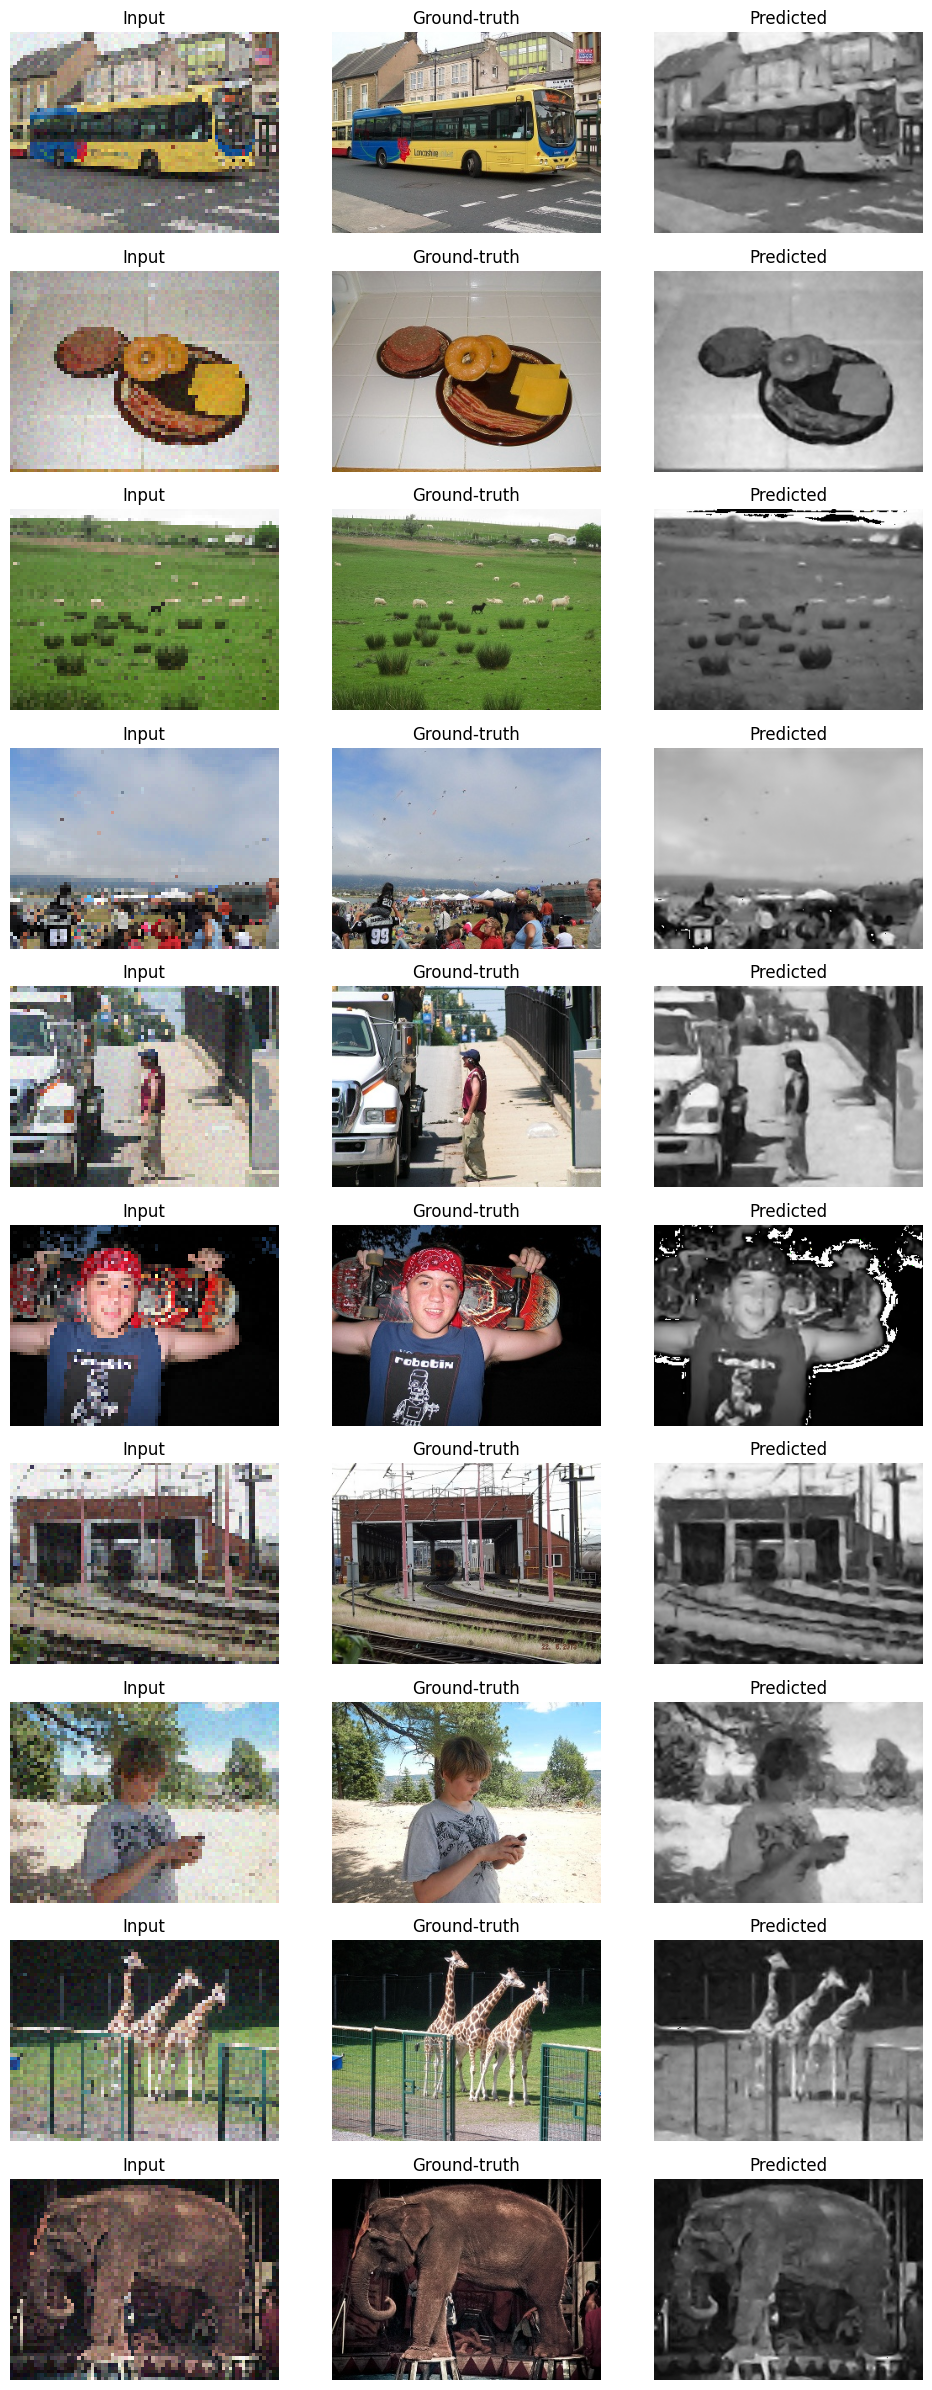

In [28]:
def calculate_PSNR2(ground_truth, output_image):

  ground_truth = ground_truth.cpu().numpy().squeeze()
  #print("Output:", ground_truth.shape) #(8, 240, 320)
  #print("GT value:", np.max(ground_truth))

  output_image = output_image.cpu().numpy().squeeze()
  #print("Output:", output_image.shape) #(8, 240, 320)
  #print("Output value:", np.max(output_image)) #

  data_range=1.

  PSNR = 0
  for i in range(output_image.shape[0]):
        PSNR += peak_signal_noise_ratio(ground_truth[i,:,:], output_image[i,:,:], data_range=data_range)

  #print("PSNR:", PSNR/output_image.shape[0])

  return (PSNR/output_image.shape[0])


psnr_sum = 0.0
num_images = 0

# measure the performance of your model
model.eval()
with torch.no_grad():
    predicted_masks = []
    for images_y, images_ycc, _, ground_truth_y in test_dataloader:
        images_y, ground_truth_y = images_y.to(device), ground_truth_y.to(device)
        output = model(images_y)

        psnr=calculate_PSNR2(ground_truth_y, output)
        psnr_sum += psnr
        num_images += 1

        images_ycc= images_ycc.cpu().numpy()


        output_image = output.cpu().numpy().squeeze()

        #print("Shape:", output_image.shape) #(8, 240, 320)

        rgb_images=  np.zeros((images_ycc.shape[0], images_ycc.shape[2], images_ycc.shape[3], 3), dtype=np.uint8)

        for i in range(images_ycc.shape[0]):

          y_channel = (output_image[i]) #.astype(np.uint8)
          cr_channel = (images_ycc[i, 1, :, :] ) #.astype(np.uint8)
          cb_channel = (images_ycc[i, 2, :, :] ) #.astype(np.uint8)

          #print("Shape1:", images_ycc.shape) #(8, 3, 240, 320)

          ycc_image  = cv2.merge([y_channel, cr_channel, cb_channel])
          #print("Shape1:", ycc_image.shape) #(3, 240, 320)

          ycc_image=ycc_image #.astype(np.uint8)

          rgb_image = cv2.cvtColor(ycc_image, cv2.COLOR_YCrCb2RGB)
          rgb_images[i]= rgb_image


        predicted_masks.extend(rgb_images)


average_psnr = psnr_sum / num_images
print("Average PSNR on test set:", average_psnr)

display_image_grid(test_list[:10], images_directory='dataset', predicted_masks=predicted_masks[:10])
